In [264]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
#register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [265]:
# !wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv

In [266]:
df2 = pd.read_csv('../data/OxCGRT_USA_latest.csv')
df2.head()

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1M_School closing,C1M_Flag,C2M_Workplace closing,C2M_Flag,...,MajorityVaccinated,PopulationVaccinated,StringencyIndex_Average,StringencyIndex_Average_ForDisplay,GovernmentResponseIndex_Average,GovernmentResponseIndex_Average_ForDisplay,ContainmentHealthIndex_Average,ContainmentHealthIndex_Average_ForDisplay,EconomicSupportIndex,EconomicSupportIndex_ForDisplay
0,United States,USA,NaN,NaN,NAT_TOTAL,20200101,0.0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,United States,USA,NaN,NaN,NAT_TOTAL,20200102,0.0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,United States,USA,NaN,NaN,NAT_TOTAL,20200103,0.0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,United States,USA,NaN,NaN,NAT_TOTAL,20200104,0.0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,United States,USA,NaN,NaN,NAT_TOTAL,20200105,0.0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [267]:
#df2 = df2['CountryName' == 'United States']
df2 = df2[df2['CountryName'] == 'United States']
df2 = df2[df2['Jurisdiction'] == 'NAT_TOTAL']
print(df2.shape)

# remove some columns V2B_Vaccine age eligibility/availability age floor (general population summary)
df2 = df2.drop(['CountryName', 'CountryCode', 'RegionName', 'RegionCode', 'Jurisdiction', 'Date'], axis=1)
df2 = df2.drop(['V2B_Vaccine age eligibility/availability age floor (general population summary)','V2C_Vaccine age eligibility/availability age floor (at risk summary)','MajorityVaccinated'], axis=1)


df2 = df2.iloc[76:, :]
df2 = df2.reset_index(drop=True)
df2.head()

(1096, 61)


,C1M_School closing,C1M_Flag,C2M_Workplace closing,C2M_Flag,C3M_Cancel public events,C3M_Flag,C4M_Restrictions on gatherings,C4M_Flag,C5M_Close public transport,C5M_Flag,...,ConfirmedDeaths,PopulationVaccinated,StringencyIndex_Average,StringencyIndex_Average_ForDisplay,GovernmentResponseIndex_Average,GovernmentResponseIndex_Average_ForDisplay,ContainmentHealthIndex_Average,ContainmentHealthIndex_Average_ForDisplay,EconomicSupportIndex,EconomicSupportIndex_ForDisplay
0,3.0,0.0,0.0,NaN,2.0,0.0,2.0,0.0,1.0,0.0,...,134.0,0.0,55.09,55.09,42.19,42.19,48.21,48.21,0.0,0.0
1,3.0,0.0,0.0,NaN,2.0,0.0,2.0,0.0,1.0,0.0,...,194.0,0.0,55.09,55.09,42.19,42.19,48.21,48.21,0.0,0.0
2,3.0,0.0,3.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,...,266.0,0.0,67.13,67.13,48.96,48.96,55.95,55.95,0.0,0.0
3,3.0,0.0,3.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,...,372.0,0.0,67.13,67.13,48.96,48.96,55.95,55.95,0.0,0.0
4,3.0,0.0,3.0,0.0,2.0,0.0,4.0,0.0,1.0,0.0,...,475.0,0.0,72.69,72.69,52.08,52.08,59.52,59.52,0.0,0.0


In [268]:
df = pd.read_csv('../data/time_series_covid19_confirmed_US.csv')
df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,19732,19759,19759,19759,19759,19759,19759,19759,19790,19790
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,69641,69767,69767,69767,69767,69767,69767,69767,69860,69860
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,7451,7474,7474,7474,7474,7474,7474,7474,7485,7485
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,8067,8087,8087,8087,8087,8087,8087,8087,8091,8091
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,18616,18673,18673,18673,18673,18673,18673,18673,18704,18704


In [269]:
df = df.iloc[:, 11:]
df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,0,0,0,0,0,0,0,0,0,0,...,19732,19759,19759,19759,19759,19759,19759,19759,19790,19790
1,0,0,0,0,0,0,0,0,0,0,...,69641,69767,69767,69767,69767,69767,69767,69767,69860,69860
2,0,0,0,0,0,0,0,0,0,0,...,7451,7474,7474,7474,7474,7474,7474,7474,7485,7485
3,0,0,0,0,0,0,0,0,0,0,...,8067,8087,8087,8087,8087,8087,8087,8087,8091,8091
4,0,0,0,0,0,0,0,0,0,0,...,18616,18673,18673,18673,18673,18673,18673,18673,18704,18704


In [270]:
df.isnull().sum().sum()

0

In [271]:
daily_cases = df.sum(axis=0)

daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases = daily_cases[:-47]
daily_cases.reset_index(drop=True, inplace=True)



#df2.index = pd.to_datetime(df2.index)
daily_cases = pd.concat([daily_cases, df2], axis=1)
# replace Nan with 0
daily_cases = daily_cases.fillna(0)
daily_cases.head()

,0,C1M_School closing,C1M_Flag,C2M_Workplace closing,C2M_Flag,C3M_Cancel public events,C3M_Flag,C4M_Restrictions on gatherings,C4M_Flag,C5M_Close public transport,...,ConfirmedDeaths,PopulationVaccinated,StringencyIndex_Average,StringencyIndex_Average_ForDisplay,GovernmentResponseIndex_Average,GovernmentResponseIndex_Average_ForDisplay,ContainmentHealthIndex_Average,ContainmentHealthIndex_Average_ForDisplay,EconomicSupportIndex,EconomicSupportIndex_ForDisplay
0,1,3.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,1.0,...,134.0,0.0,55.09,55.09,42.19,42.19,48.21,48.21,0.0,0.0
1,1,3.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,1.0,...,194.0,0.0,55.09,55.09,42.19,42.19,48.21,48.21,0.0,0.0
2,2,3.0,0.0,3.0,0.0,2.0,0.0,2.0,0.0,1.0,...,266.0,0.0,67.13,67.13,48.96,48.96,55.95,55.95,0.0,0.0
3,2,3.0,0.0,3.0,0.0,2.0,0.0,2.0,0.0,1.0,...,372.0,0.0,67.13,67.13,48.96,48.96,55.95,55.95,0.0,0.0
4,5,3.0,0.0,3.0,0.0,2.0,0.0,4.0,0.0,1.0,...,475.0,0.0,72.69,72.69,52.08,52.08,59.52,59.52,0.0,0.0


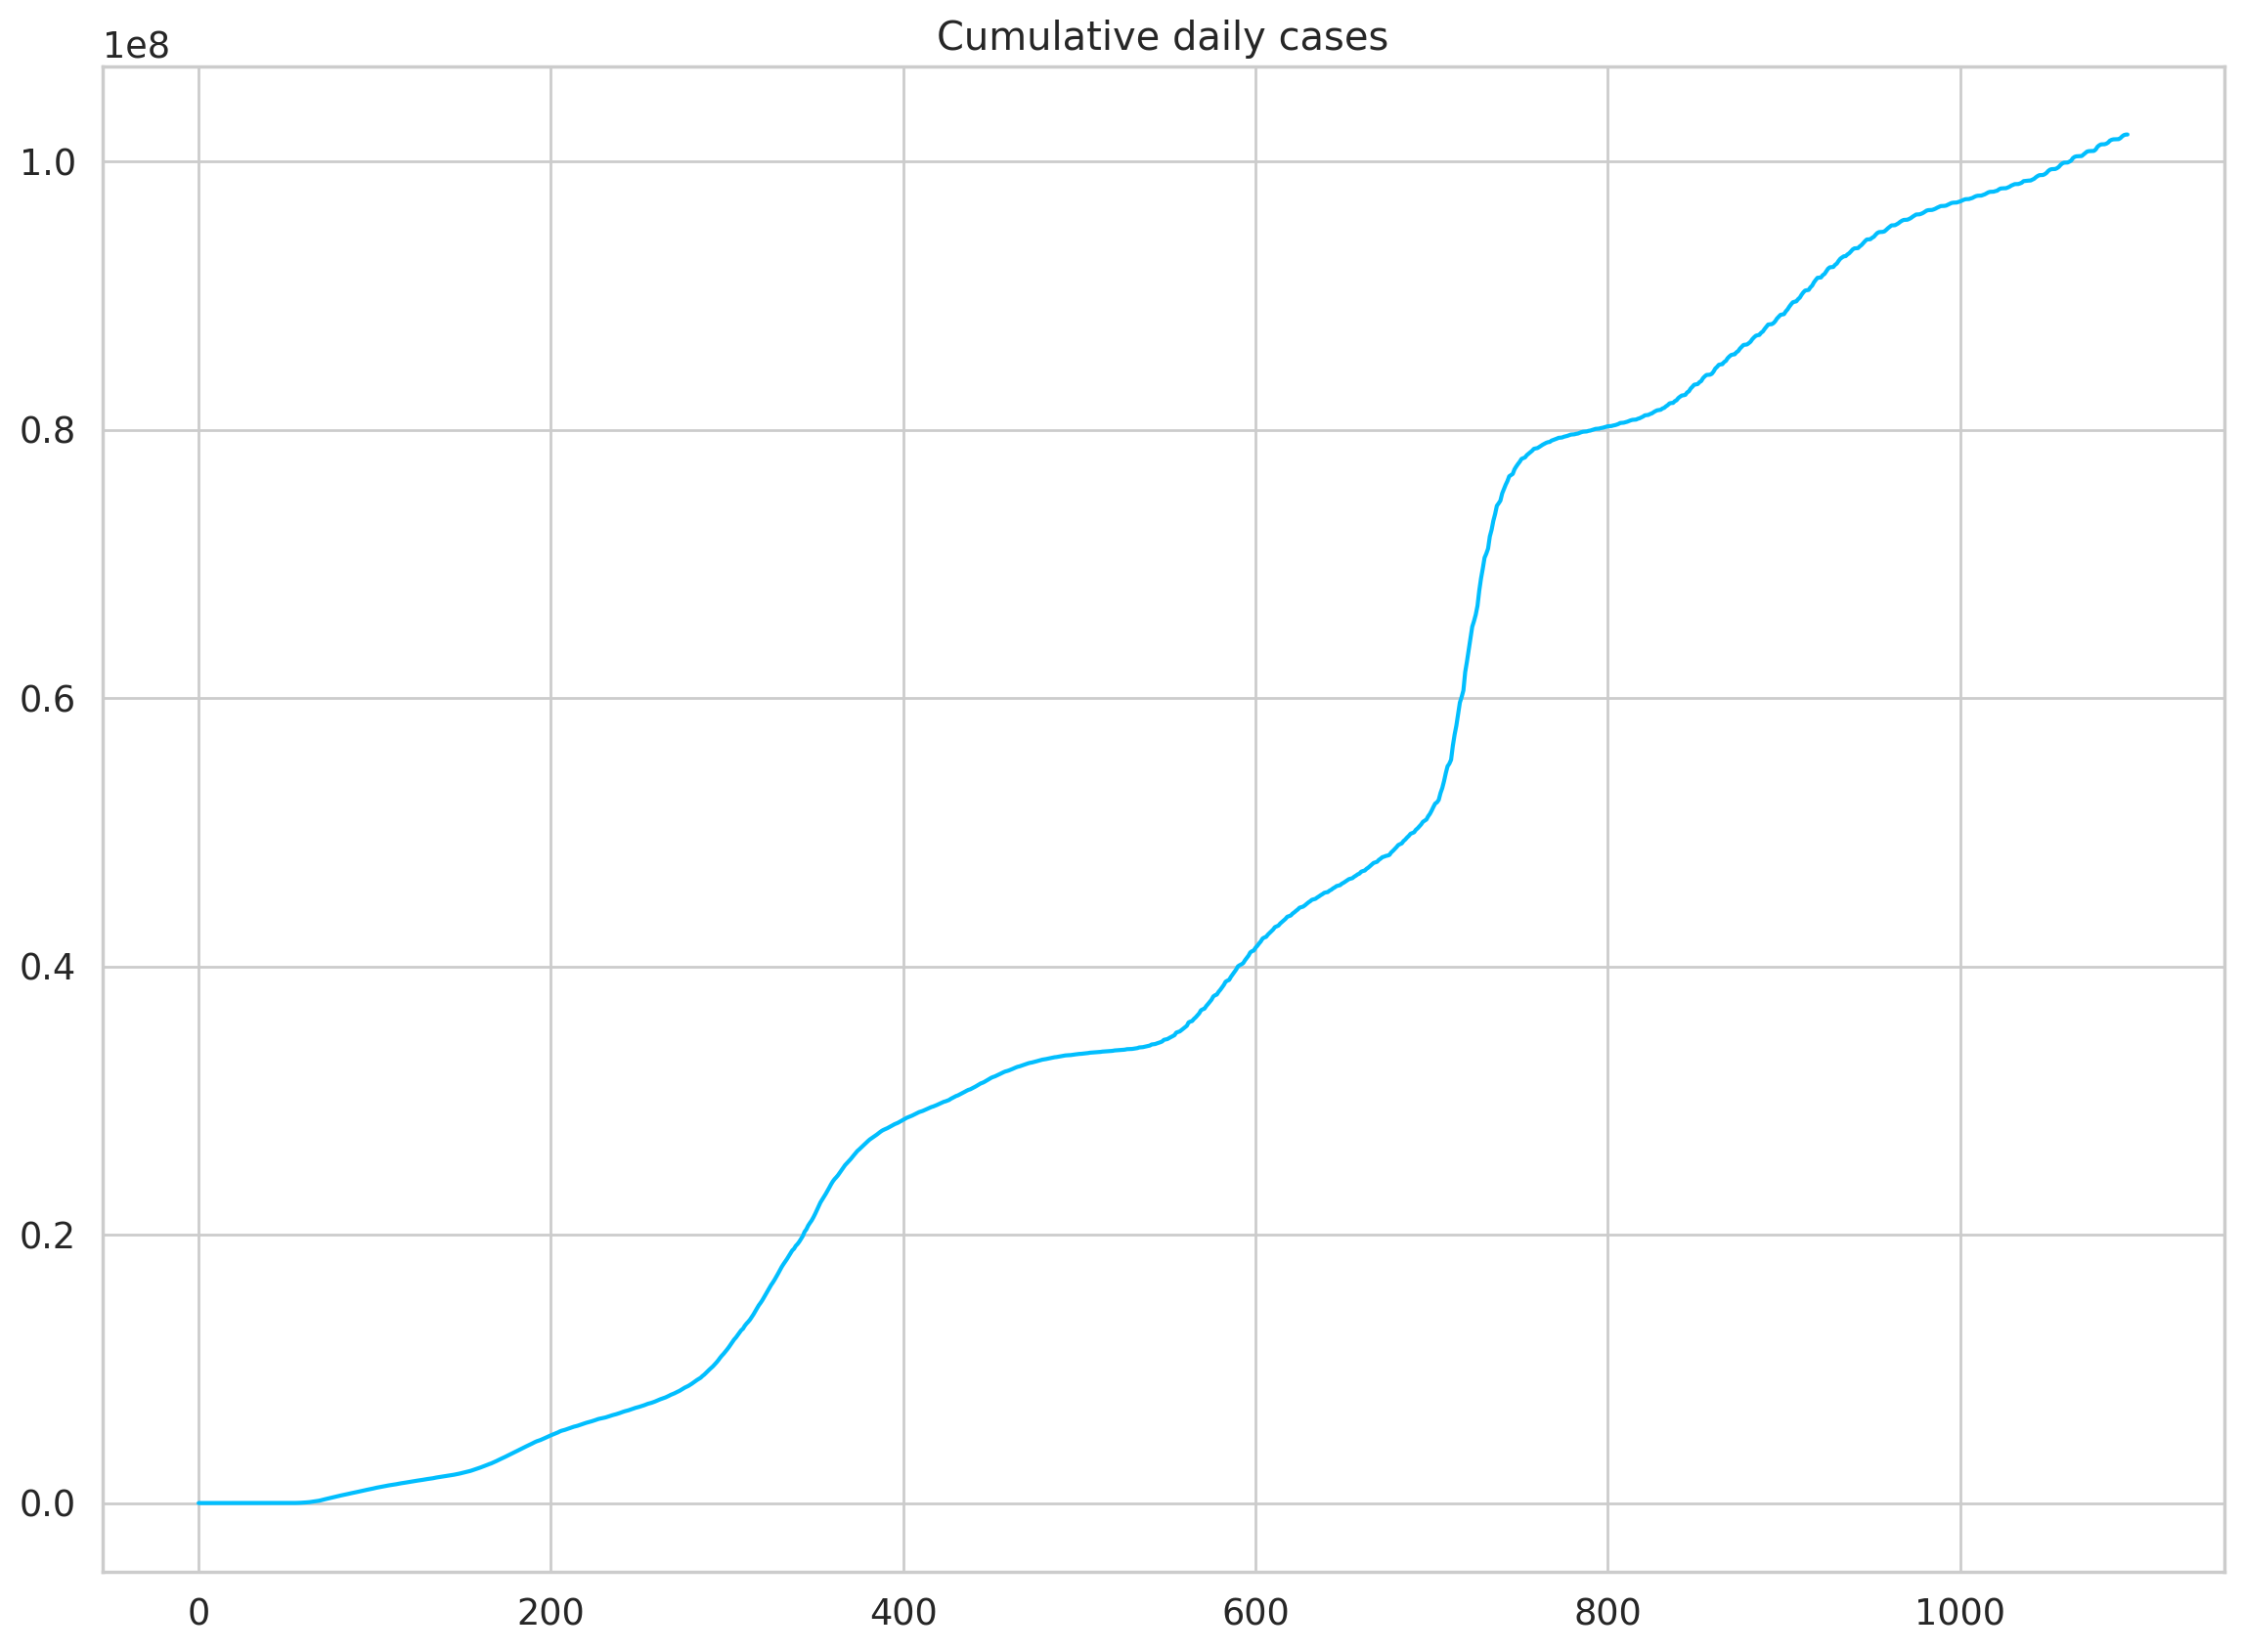

In [272]:
plt.plot(daily_cases[0])
plt.title("Cumulative daily cases");

In [273]:
daily_cases[0] = daily_cases[0].diff().fillna(daily_cases[0])

daily_cases.astype(np.float32)
daily_cases.head()

,0,C1M_School closing,C1M_Flag,C2M_Workplace closing,C2M_Flag,C3M_Cancel public events,C3M_Flag,C4M_Restrictions on gatherings,C4M_Flag,C5M_Close public transport,...,ConfirmedDeaths,PopulationVaccinated,StringencyIndex_Average,StringencyIndex_Average_ForDisplay,GovernmentResponseIndex_Average,GovernmentResponseIndex_Average_ForDisplay,ContainmentHealthIndex_Average,ContainmentHealthIndex_Average_ForDisplay,EconomicSupportIndex,EconomicSupportIndex_ForDisplay
0,1.0,3.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,1.0,...,134.0,0.0,55.09,55.09,42.19,42.19,48.21,48.21,0.0,0.0
1,0.0,3.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,1.0,...,194.0,0.0,55.09,55.09,42.19,42.19,48.21,48.21,0.0,0.0
2,1.0,3.0,0.0,3.0,0.0,2.0,0.0,2.0,0.0,1.0,...,266.0,0.0,67.13,67.13,48.96,48.96,55.95,55.95,0.0,0.0
3,0.0,3.0,0.0,3.0,0.0,2.0,0.0,2.0,0.0,1.0,...,372.0,0.0,67.13,67.13,48.96,48.96,55.95,55.95,0.0,0.0
4,3.0,3.0,0.0,3.0,0.0,2.0,0.0,4.0,0.0,1.0,...,475.0,0.0,72.69,72.69,52.08,52.08,59.52,59.52,0.0,0.0


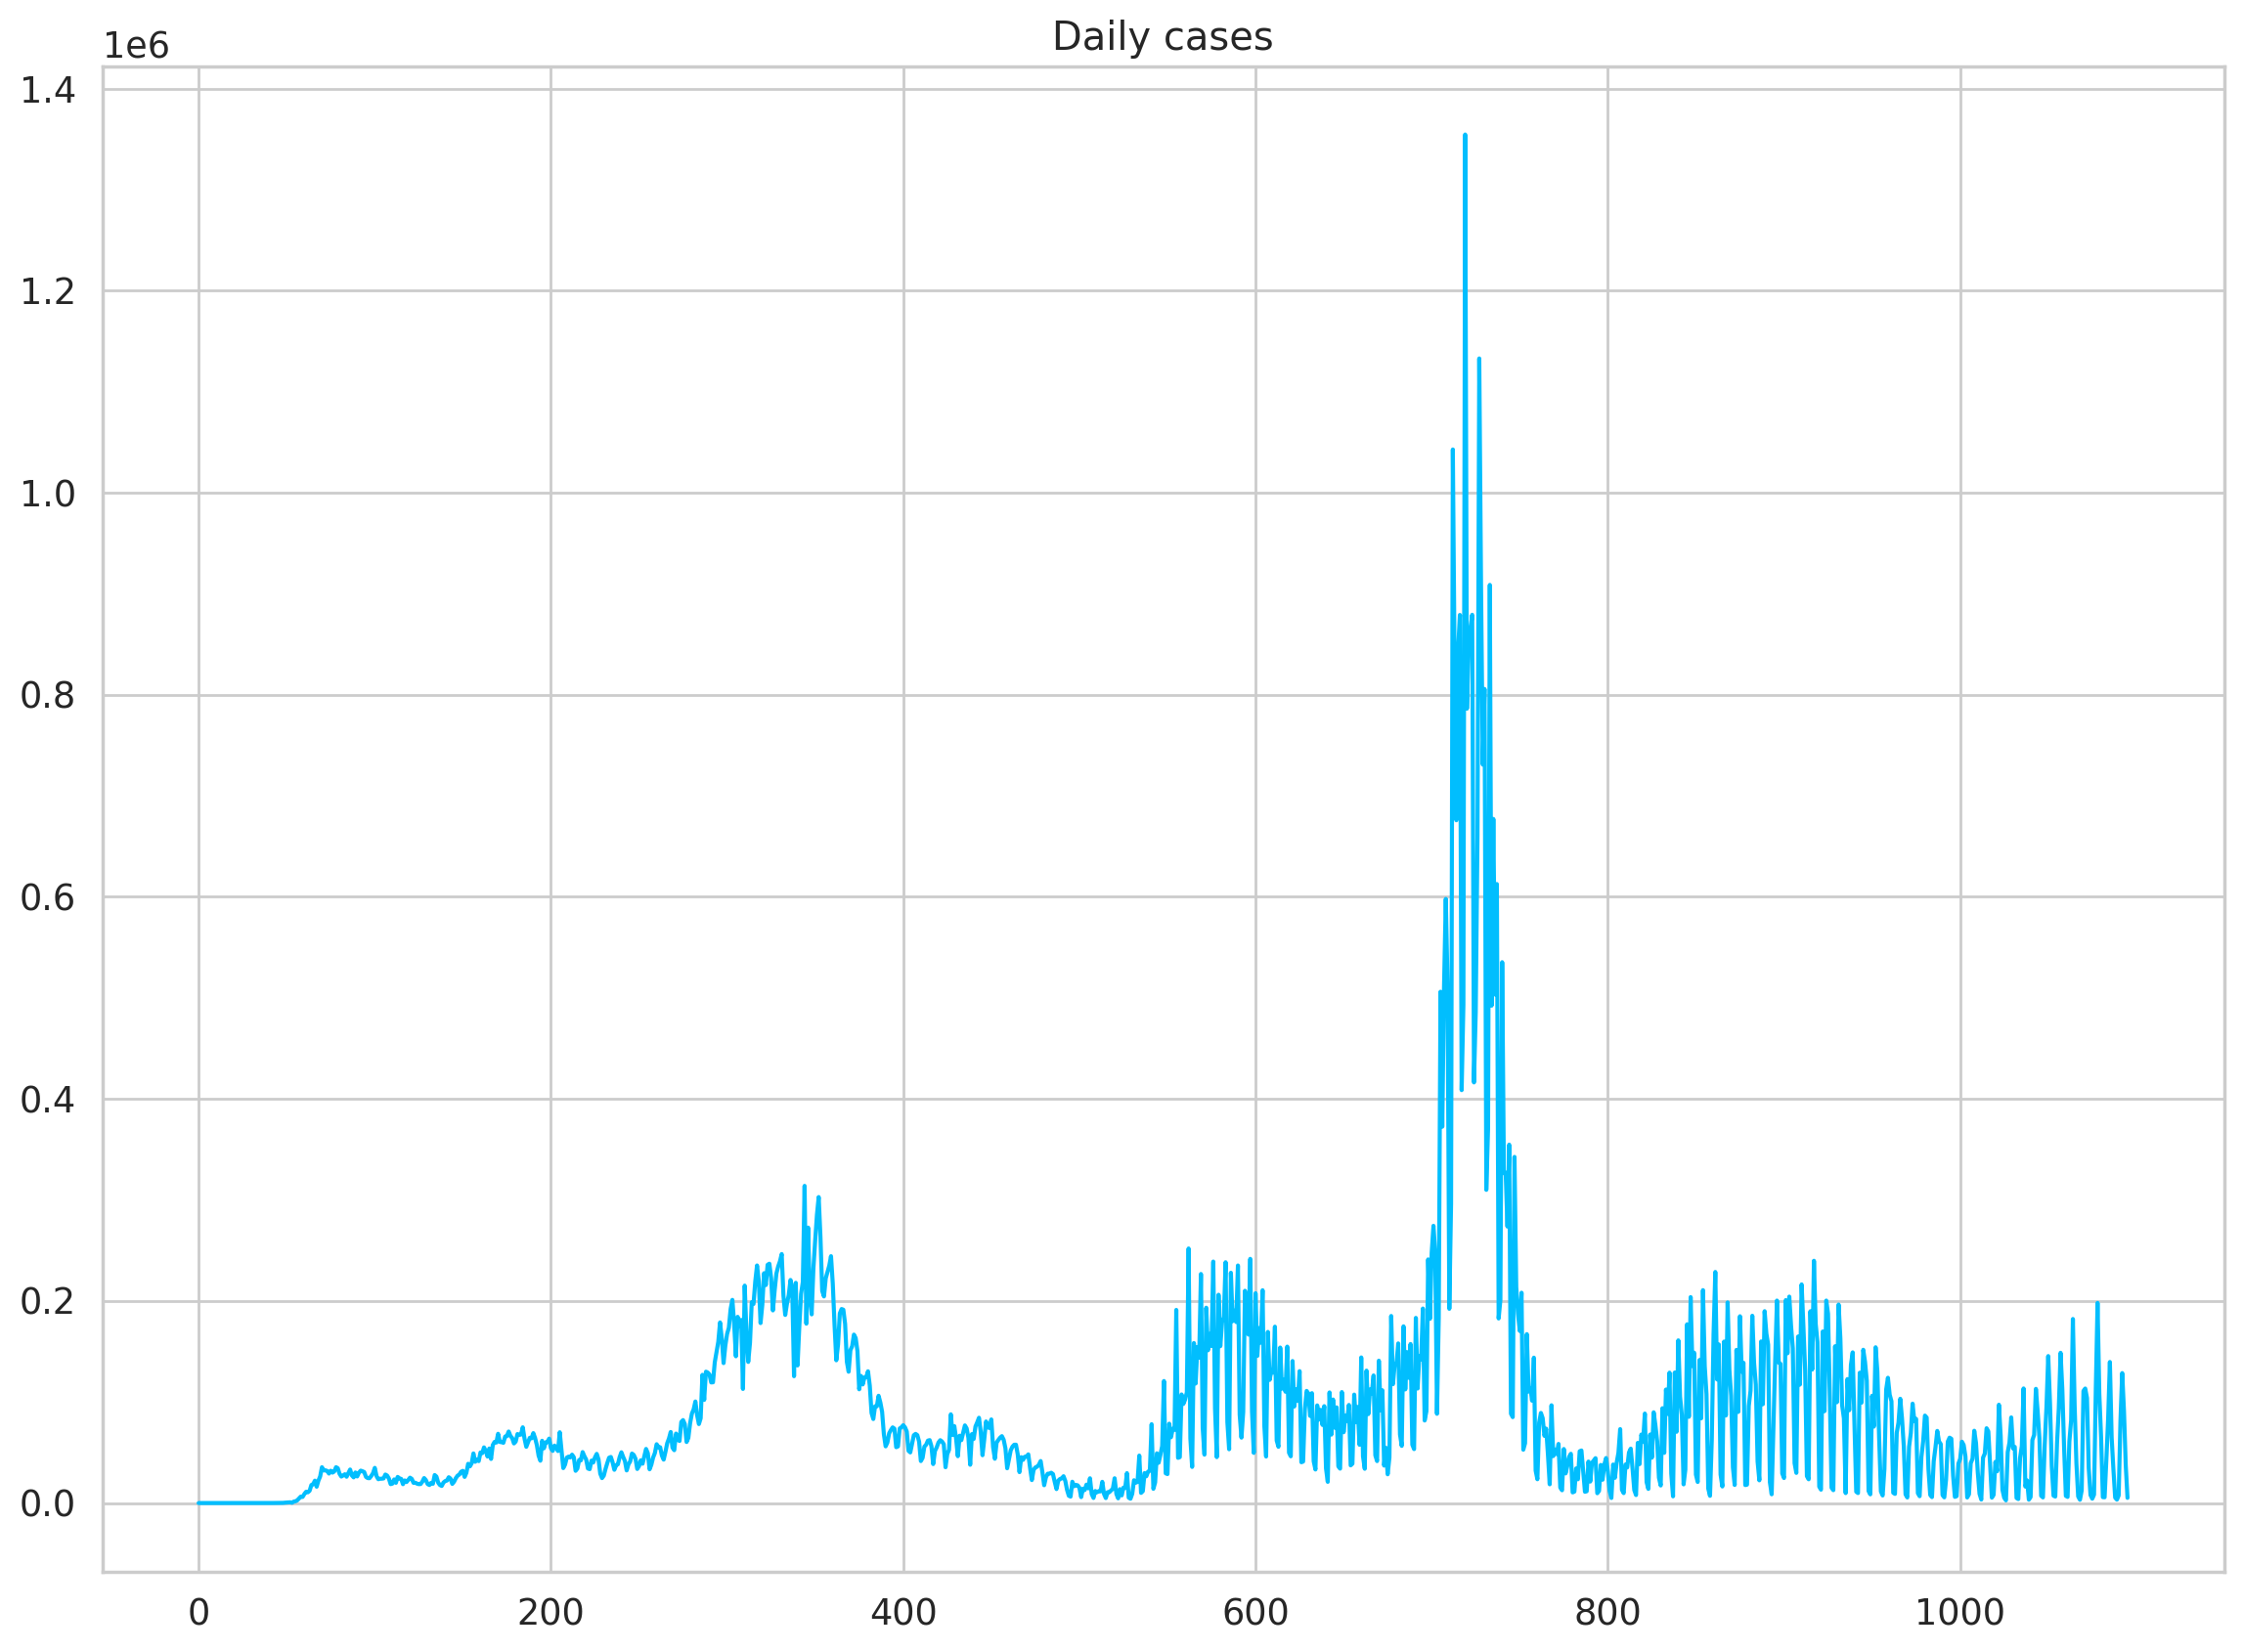

In [274]:
plt.plot(daily_cases[0])
plt.title("Daily cases");

In [275]:
days = daily_cases.shape[0]

print('We have data for ' + str(days))

We have data for 1096


In [276]:
test_data_size = 28

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape

(1068, 53)

In [283]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

[[[1.0000e+00 3.0000e+00 0.0000e+00 ... 4.8210e+01 0.0000e+00 0.0000e+00]]

 [[0.0000e+00 3.0000e+00 0.0000e+00 ... 4.8210e+01 0.0000e+00 0.0000e+00]]

 [[1.0000e+00 3.0000e+00 0.0000e+00 ... 5.5950e+01 0.0000e+00 0.0000e+00]]

 ...

 [[9.6188e+04 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]]

 [[3.9236e+04 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]]

 [[6.5220e+03 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]]]


ValueError: Found array with dim 3. MinMaxScaler expected <= 2.

In [284]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [285]:
seq_length = 14
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

KeyError: 14

In [ ]:
X_train.shape

torch.Size([1100, 14, 1])

In [ ]:
X_train[:2]

tensor([[[7.3828e-07],
         [0.0000e+00],
         [7.3828e-07],
         [0.0000e+00],
         [2.2148e-06],
         [0.0000e+00],
         [0.0000e+00],
         [7.3828e-07],
         [0.0000e+00],
         [1.4766e-06],
         [0.0000e+00],
         [0.0000e+00],
         [2.2148e-06],
         [0.0000e+00]],

        [[0.0000e+00],
         [7.3828e-07],
         [0.0000e+00],
         [2.2148e-06],
         [0.0000e+00],
         [0.0000e+00],
         [7.3828e-07],
         [0.0000e+00],
         [1.4766e-06],
         [0.0000e+00],
         [0.0000e+00],
         [2.2148e-06],
         [0.0000e+00],
         [0.0000e+00]]])

In [ ]:
y_train.shape

torch.Size([1100, 1])

In [ ]:
y_train[:2]

tensor([[0.0000e+00],
        [7.3828e-07]])

In [ ]:
train_data[:10]

array([[7.38275448e-07],
       [0.00000000e+00],
       [7.38275448e-07],
       [0.00000000e+00],
       [2.21482634e-06],
       [0.00000000e+00],
       [0.00000000e+00],
       [7.38275448e-07],
       [0.00000000e+00],
       [1.47655090e-06]])

In [ ]:

class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )
    self.hidden = (self.hidden[0].to(self.device), self.hidden[1].to(self.device))

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [ ]:

def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='mean')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=1, gamma=0.5)
  num_epochs = 200

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(1,num_epochs+1):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
    scheduler.step()
  
  return model.eval(), train_hist, test_hist

In [ ]:
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=5
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
model = model.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

Using cuda device
Epoch 0 train loss: 0.011813552118837833 test loss: 0.0005656417342834175
Epoch 10 train loss: 0.009173277765512466 test loss: 0.0042072259820997715
Epoch 20 train loss: 0.00913449190557003 test loss: 0.00409016152843833
Epoch 30 train loss: 0.009136884473264217 test loss: 0.004293451551347971
Epoch 40 train loss: 0.00914984755218029 test loss: 0.004191828425973654
Epoch 50 train loss: 0.009189759381115437 test loss: 0.004238960333168507
Epoch 60 train loss: 0.00916103832423687 test loss: 0.0042489259503781796
Epoch 70 train loss: 0.009145112708210945 test loss: 0.004248803947120905
Epoch 80 train loss: 0.00913432240486145 test loss: 0.00422102864831686
Epoch 90 train loss: 0.009155415929853916 test loss: 0.004201044328510761
Epoch 100 train loss: 0.009145318530499935 test loss: 0.00422107195481658
Epoch 110 train loss: 0.009130660444498062 test loss: 0.004192085936665535
Epoch 120 train loss: 0.009150486439466476 test loss: 0.004205755889415741
Epoch 130 train loss: 

the train and test loss:

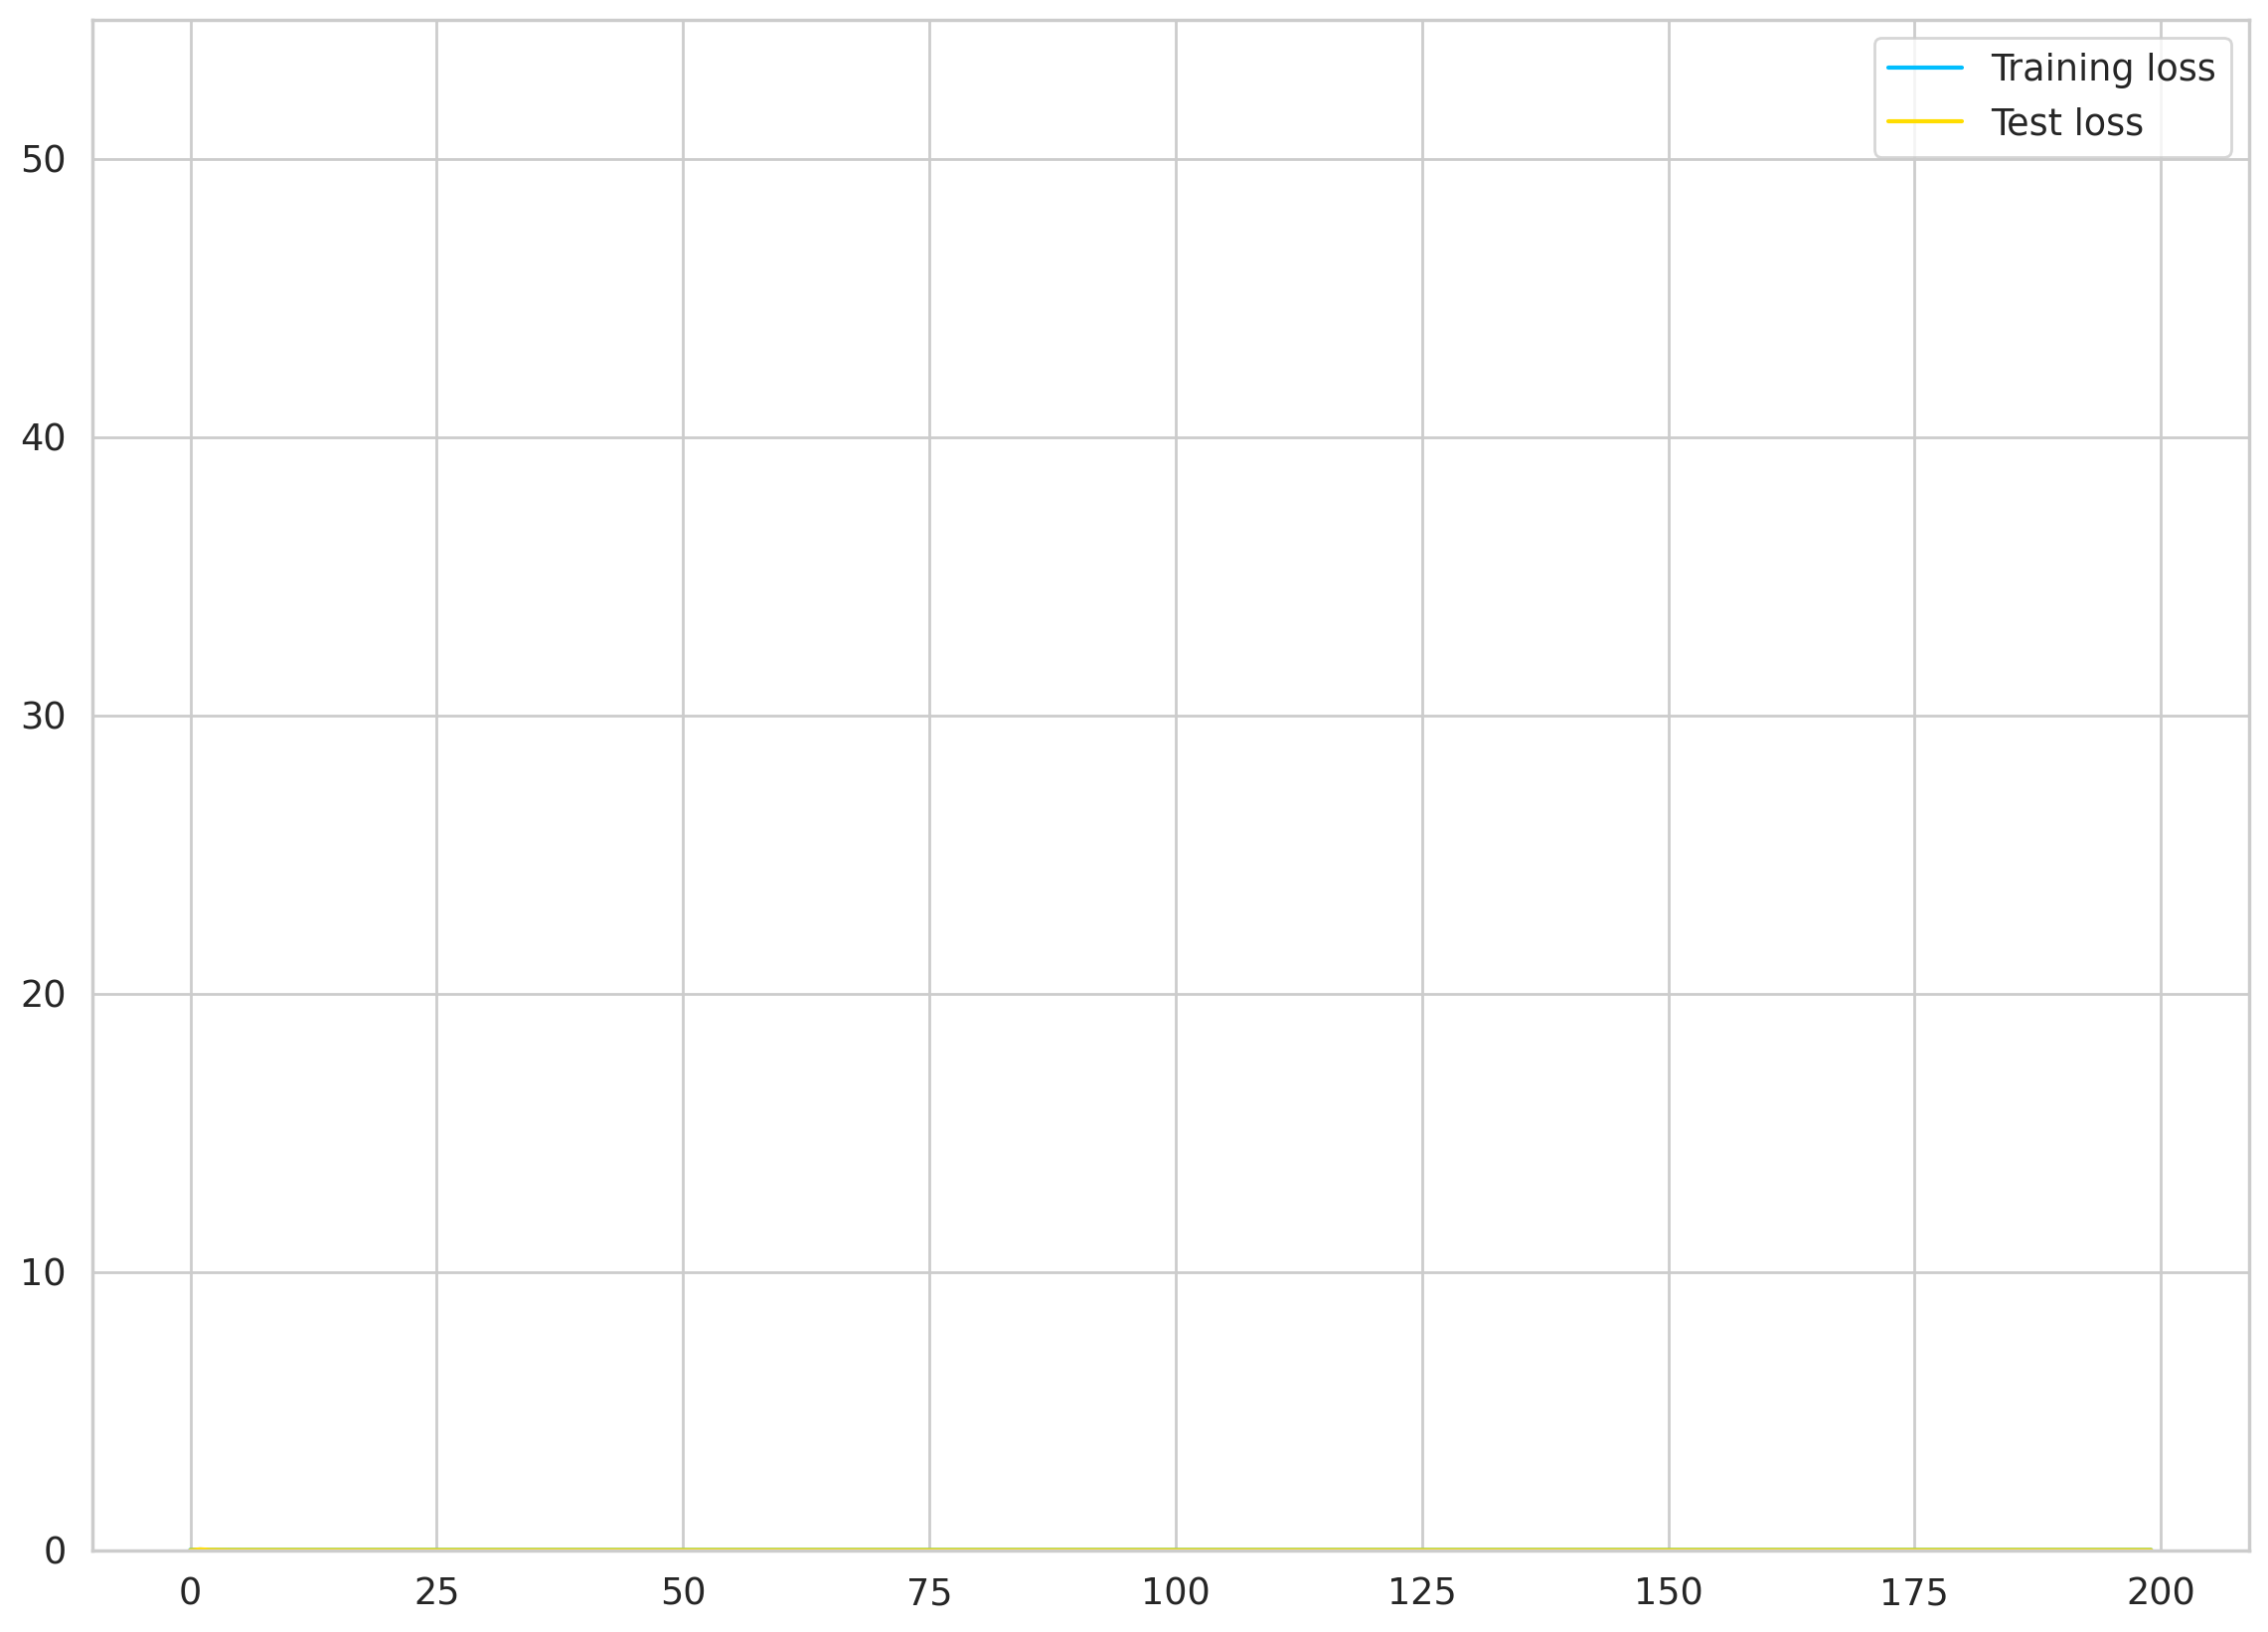

In [ ]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
#plt.ylim((0, 55))
plt.legend();

In [ ]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.cpu().numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float().cuda()

In [ ]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.cpu().flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

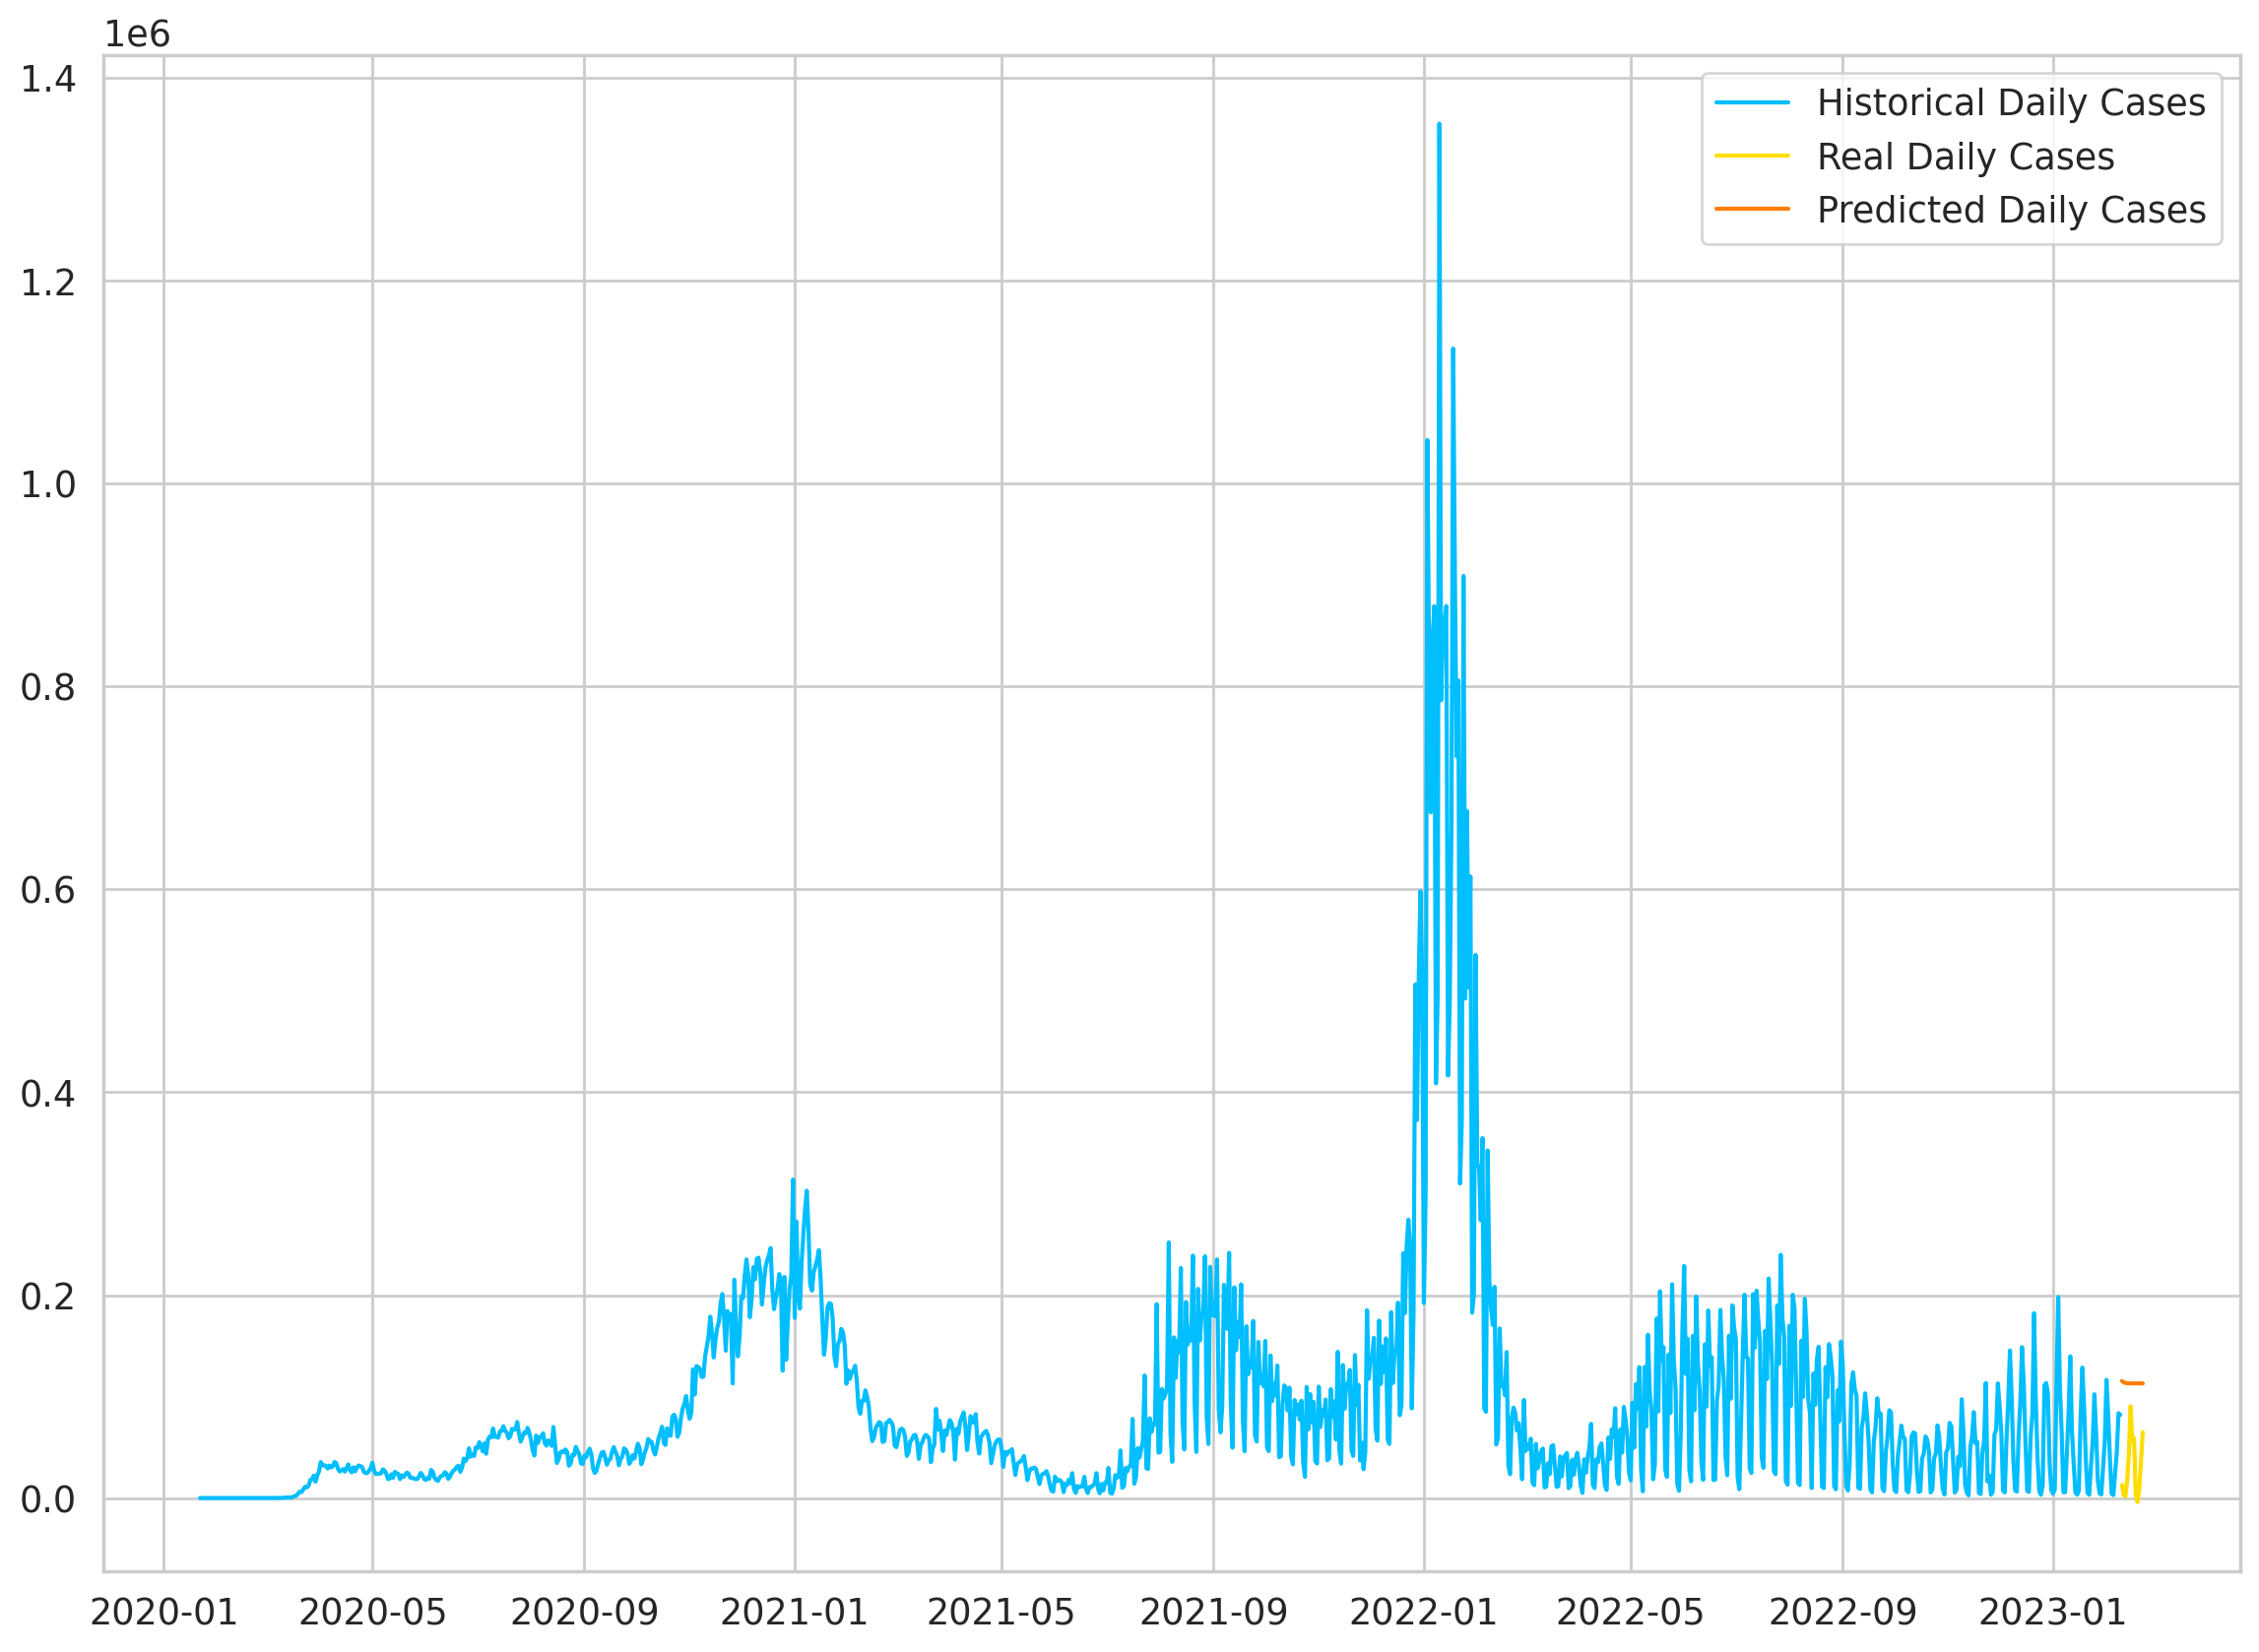

In [ ]:
plt.plot(
  daily_cases.index[:len(train_data)], 
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Daily Cases'
)

plt.legend();

In [ ]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))

all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))

all_data.shape

(1143, 1)

In [ ]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=5
)
model = model.to(device)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 0.010602944530546665
Epoch 10 train loss: 0.009218480437994003
Epoch 20 train loss: 0.009211801923811436
Epoch 30 train loss: 0.009215936064720154
Epoch 40 train loss: 0.009210493415594101
Epoch 50 train loss: 0.009231523610651493
Epoch 60 train loss: 0.00920321885496378
Epoch 70 train loss: 0.009219623170793056
Epoch 80 train loss: 0.00923160556703806
Epoch 90 train loss: 0.009195582009851933
Epoch 100 train loss: 0.009203224442899227
Epoch 110 train loss: 0.009220198728144169
Epoch 120 train loss: 0.009246407076716423
Epoch 130 train loss: 0.009215337224304676
Epoch 140 train loss: 0.00920808780938387
Epoch 150 train loss: 0.009206402115523815
Epoch 160 train loss: 0.009209936484694481
Epoch 170 train loss: 0.009244955144822598
Epoch 180 train loss: 0.009192178957164288
Epoch 190 train loss: 0.009225063025951385


In [ ]:
DAYS_TO_PREDICT = 7

with torch.no_grad():
  test_seq = X_all[:1]
  test_seq = test_seq.to(device)
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.cpu().numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float().cuda()

In [ ]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [ ]:
daily_cases.index[-1]

Timestamp('2023-03-09 00:00:00')

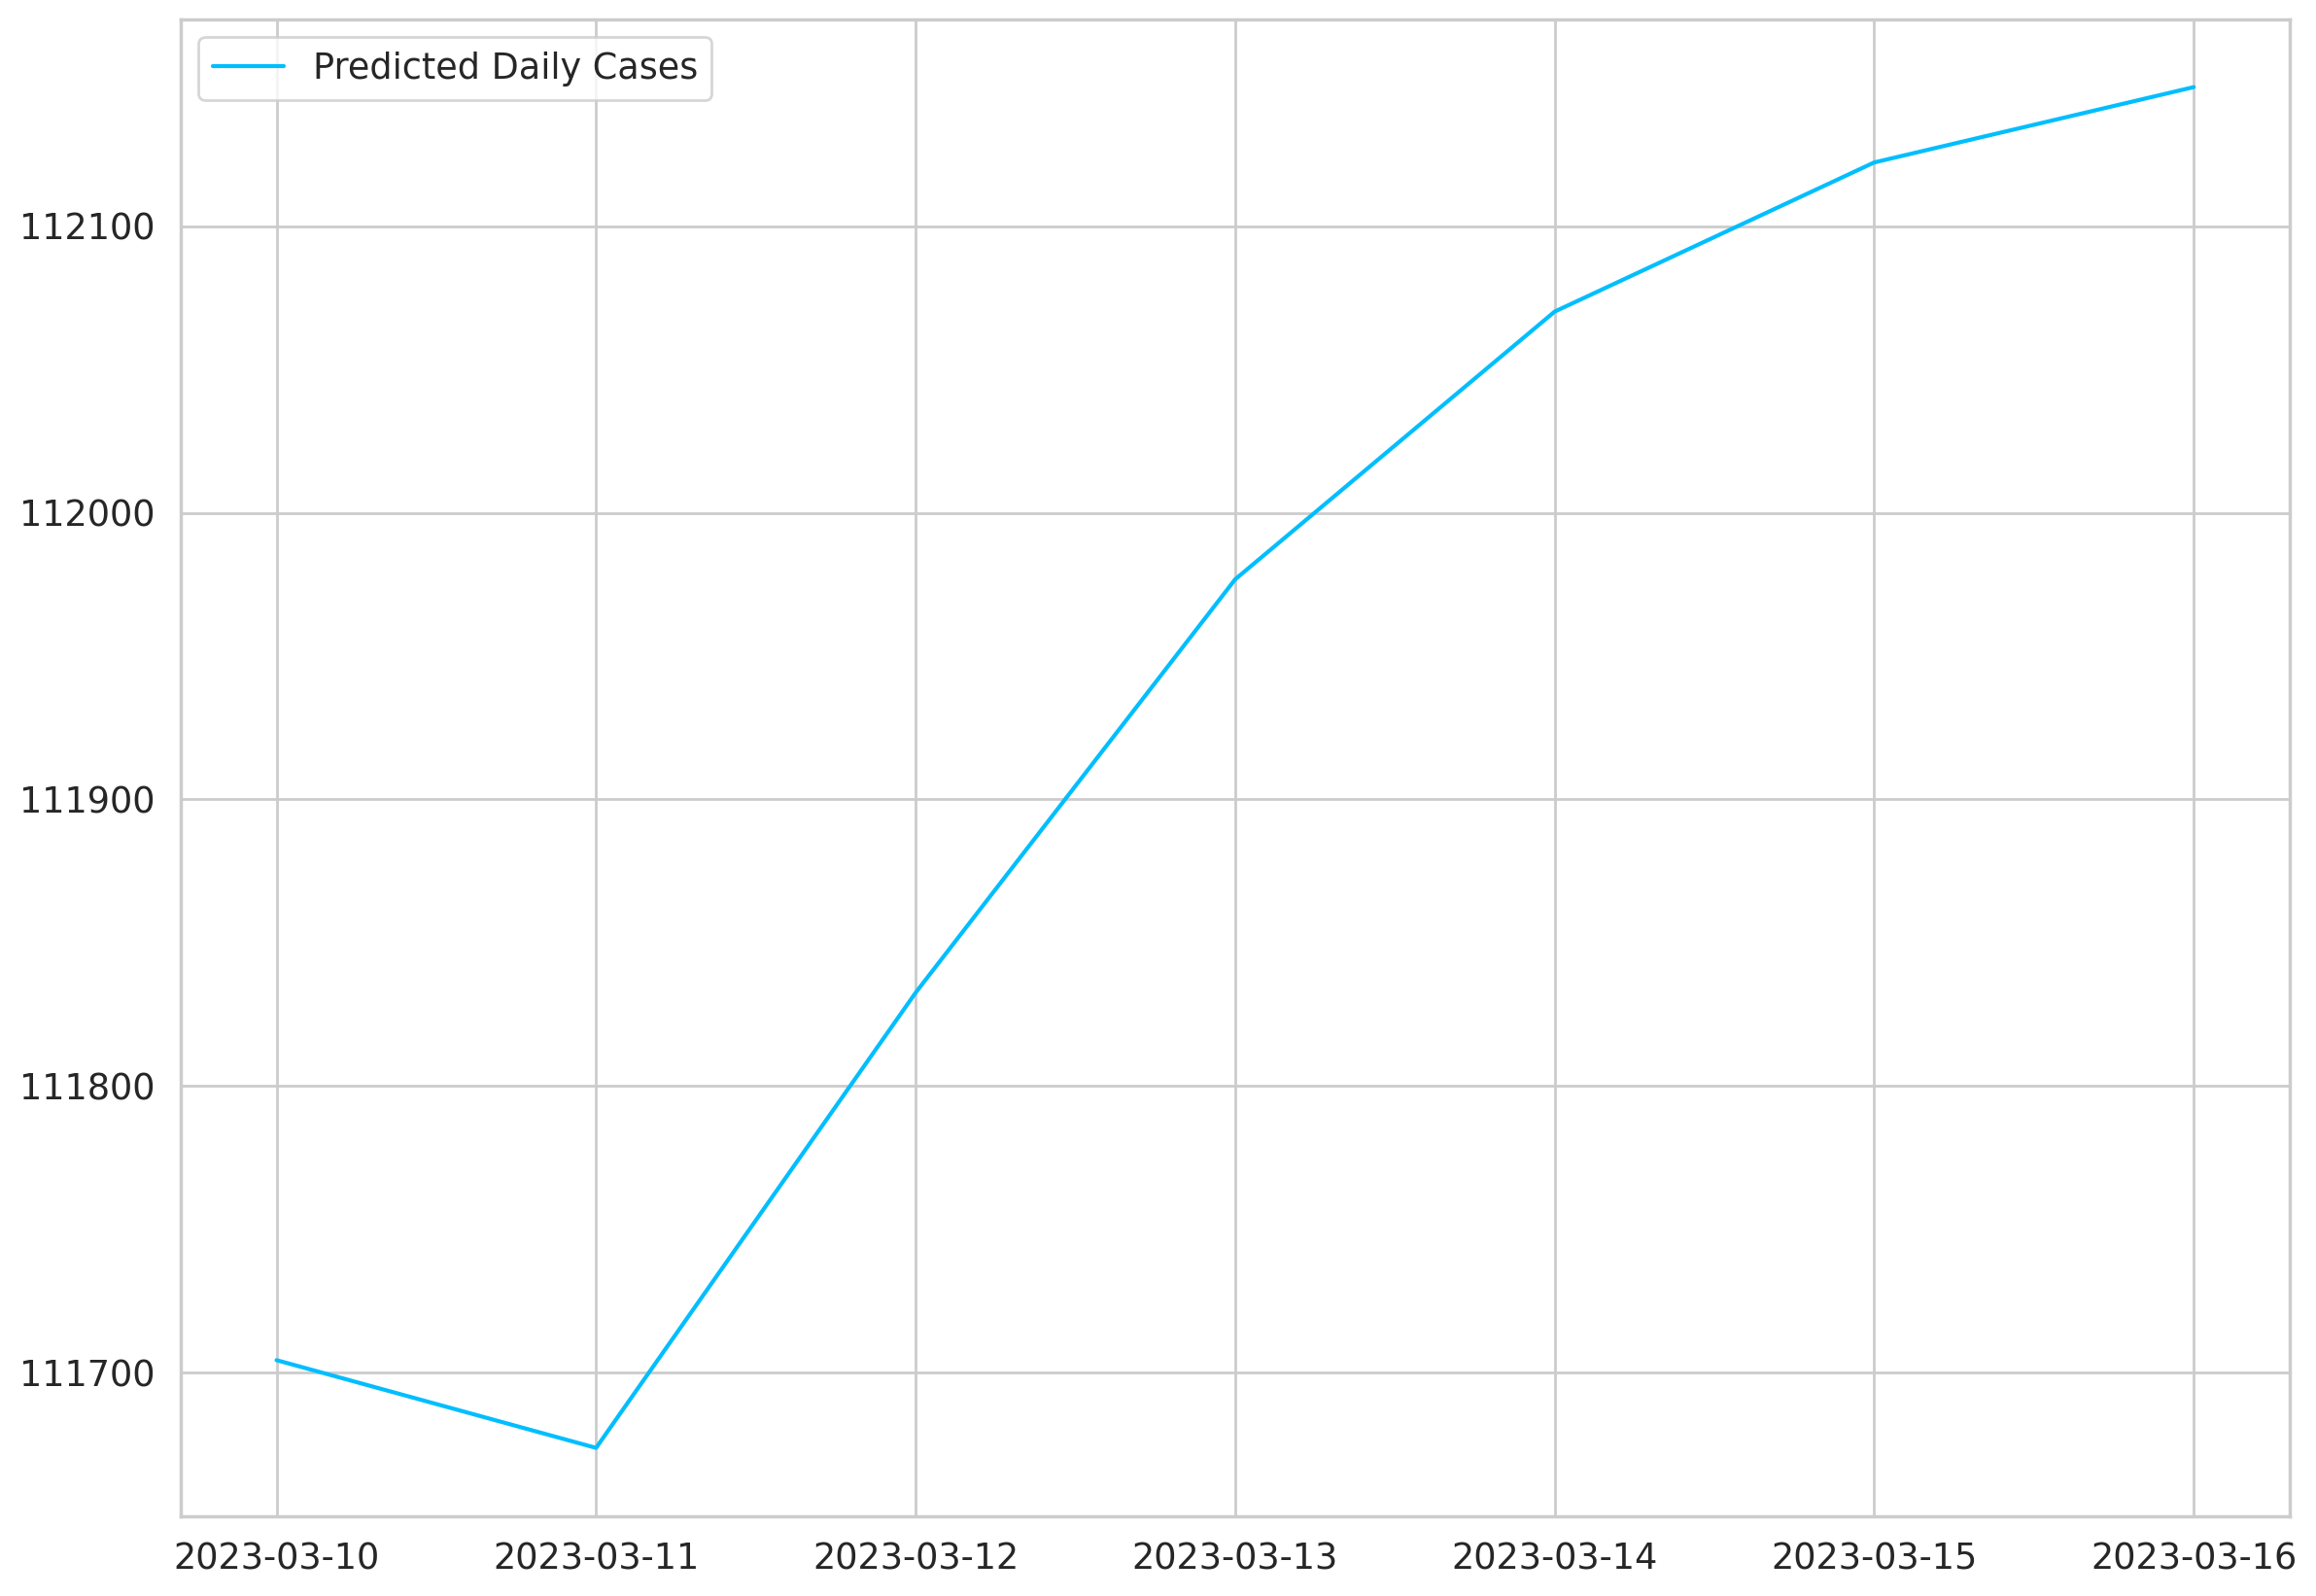

In [ ]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

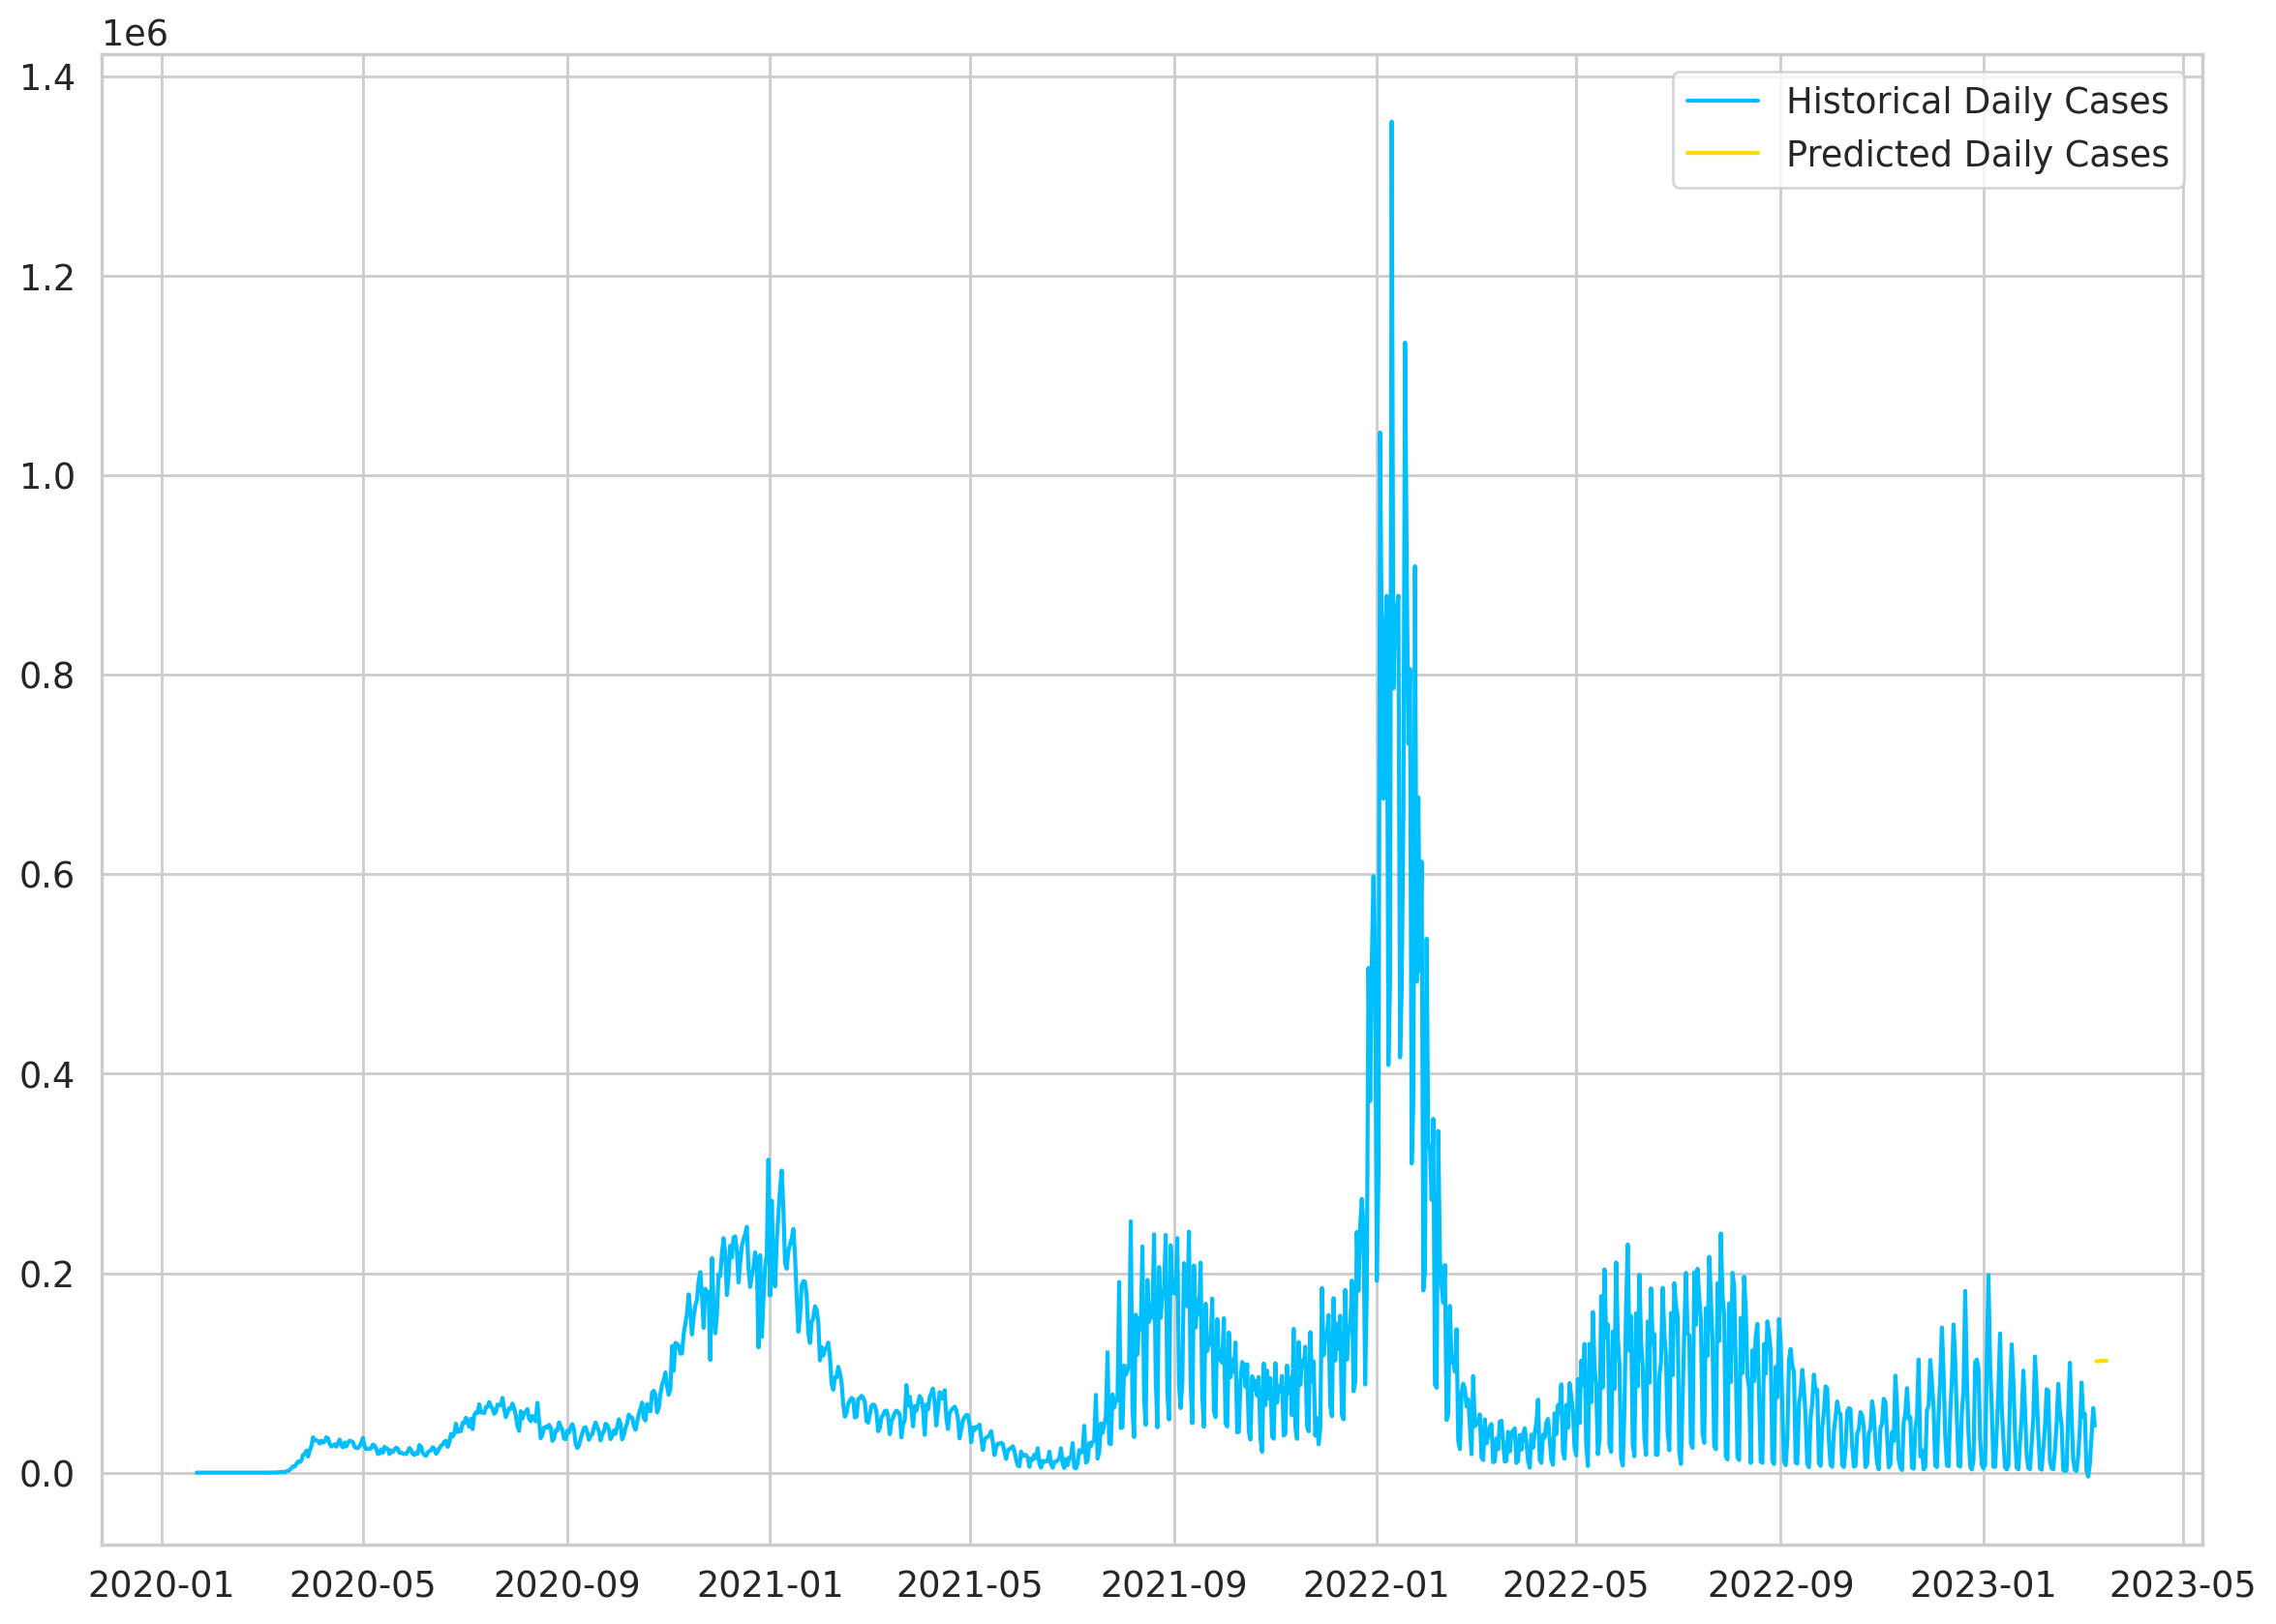

In [ ]:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();